# Setup

In [1]:
import copy
import numpy as np
import pandas as pd
import anndata as an
import scanpy as sc
import os

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
# Make sure you run Jupyter Notebook from project root
# DO NOT RUN MULTIPLE TIMES
%cd ..
filename = "GSE72857_accession_formatted.csv"
results_file = 'write/pbmc3k.h5ad'
if not os.path.exists('write'):
    os.makedirs('write')

c:\Users\andissa\Desktop\Project Github\CS-7641-Project


In [3]:
#Code to set global figure settings (feel free to remove, I just added to make the graphs look cleaner)
sc.settings.set_figure_params(dpi=80)

In [4]:
adata = sc.read_csv(filename, first_column_names=True).T
adata

AnnData object with n_obs × n_vars = 10368 × 27297

# Preprocessing

In [5]:
count_depth = np.sum(adata.X, axis = 1)
print("count depth shape:{}".format(count_depth.shape))
#print(count_depth)
number_of_genes = np.sum(adata.X>0,axis=1)
print("number_of_genes shape:{}".format(number_of_genes.shape))
#print(number_of_genes)

count depth shape:(10368,)
number_of_genes shape:(10368,)


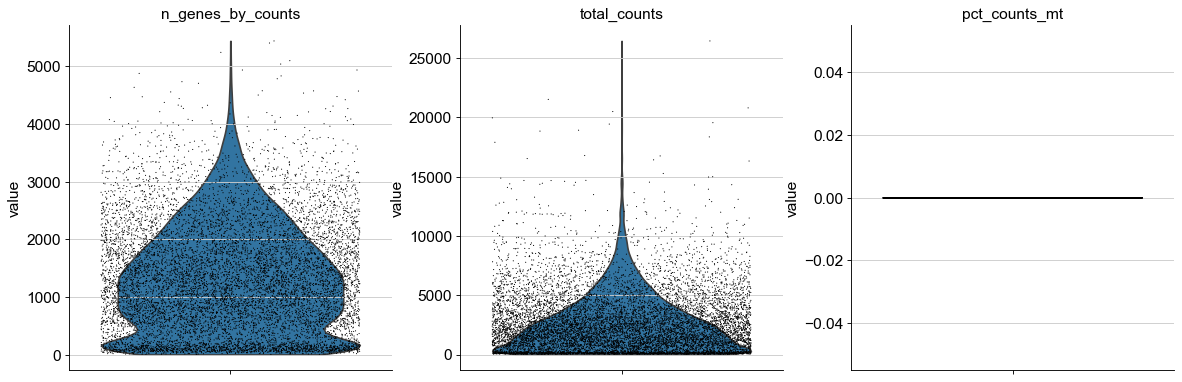

In [6]:
# when/where/why do we do violin plots? 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

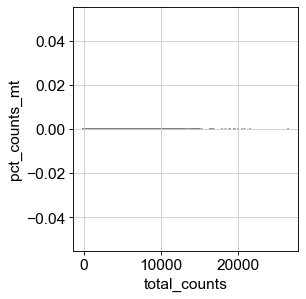

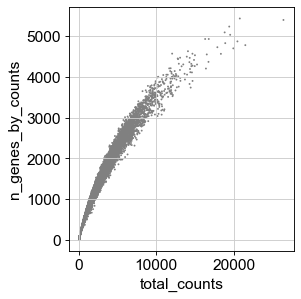

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Text(0, 0.5, 'unique genes')

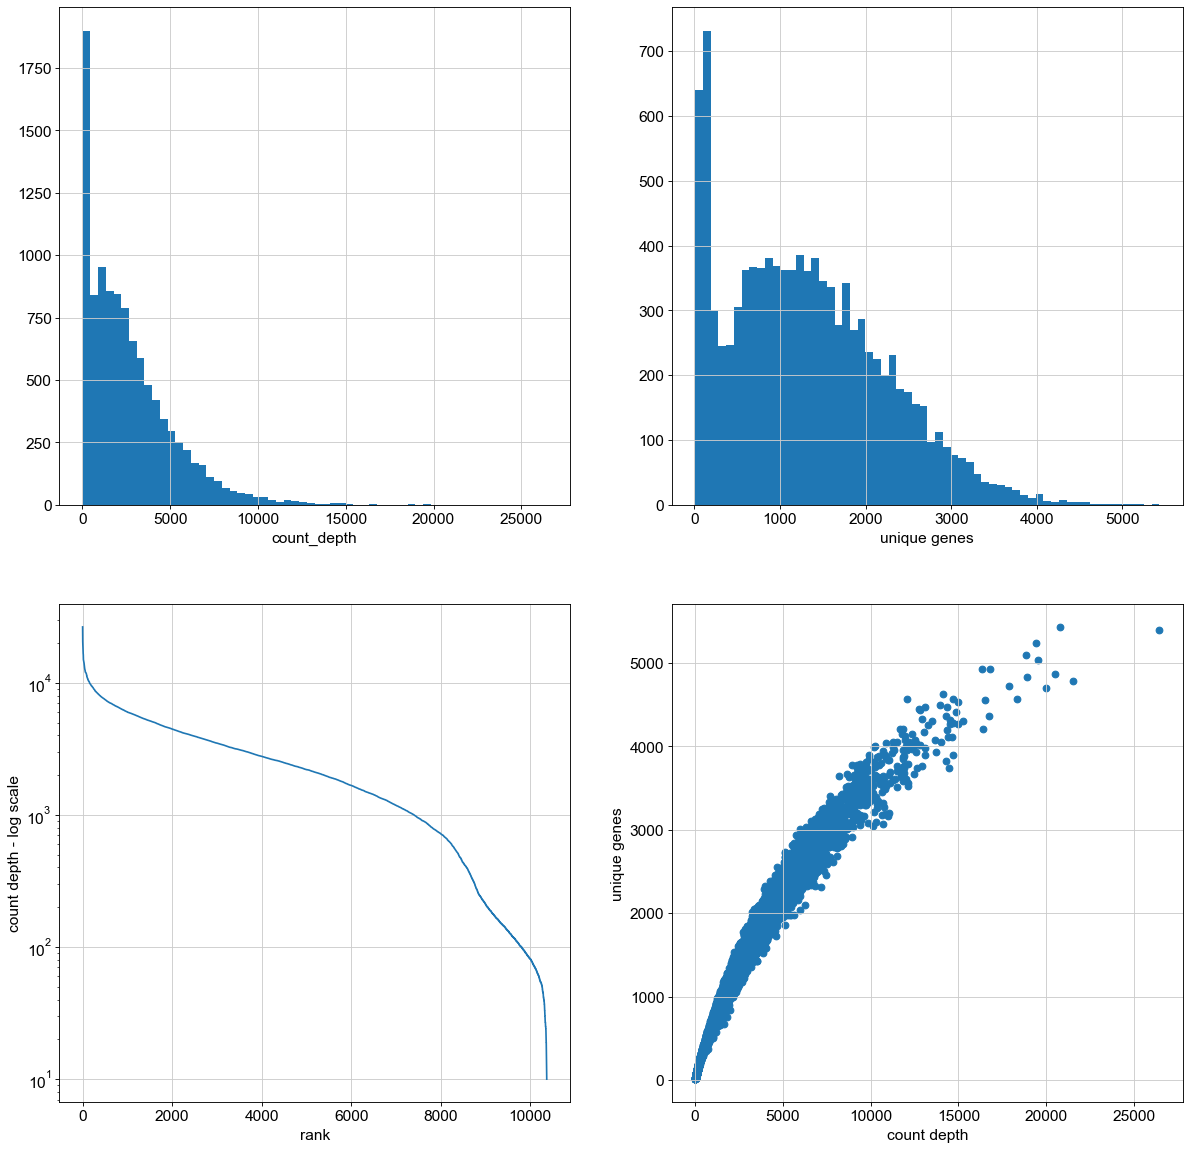

In [8]:
plt.rcParams["figure.figsize"] = [18,18]
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(count_depth,bins=60)
#axs[0,0].set_yscale("log")
axs[0,0].set_xlabel("count_depth")

axs[0,1].hist(number_of_genes,bins=60)
#axs[0,1].set_yscale("log")
axs[0,1].set_xlabel("unique genes")

axs[1,0].plot(range(len(count_depth)),sorted(count_depth,reverse=True))
axs[1,0].set_yscale("log")
axs[1,0].set_xlabel("rank")
axs[1,0].set_ylabel("count depth - log scale")

axs[1,1].scatter(count_depth,number_of_genes)
axs[1,1].set_xlabel("count depth")
axs[1,1].set_ylabel("unique genes")

Text(0.5, 0, 'unique genes')

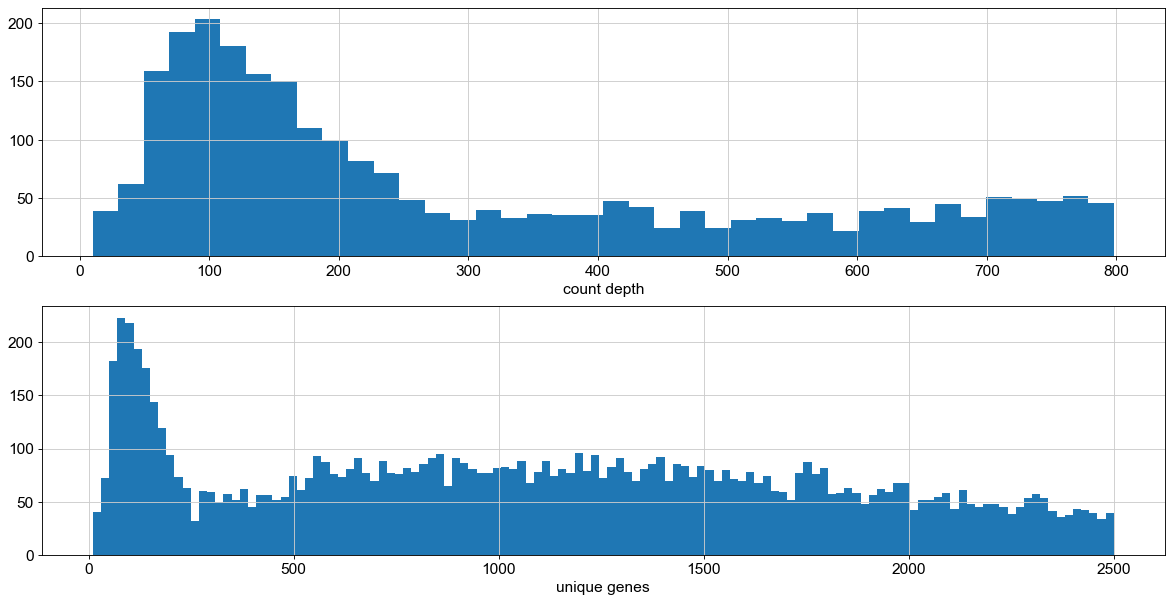

In [9]:
plt.rcParams["figure.figsize"] = [18,9]
fig2, axs2 = plt.subplots(2, 1)

mindepth = 1
maxdepth = 800
mingenes = 1
maxgenes = 2500

#axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=True)
axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=False)
#axs2[0].set_yscale("log")
axs2[0].set_xlabel("count depth")
#axs2[0].hist(count_depth[np.where((count_depth < maxdepth))], bins=21)

axs2[1].hist(number_of_genes[np.where((number_of_genes<=maxgenes) & (number_of_genes >= mingenes))],bins=min([200,int(maxgenes/20)]),cumulative=False)
#axs2[1].set_yscale("log")
axs2[1].set_xlabel("unique genes")
#axs2[1].hist(number_of_genes[np.where((number_of_genes<maxgenes) )],bins=21)

I'll have to check how this dataset was collected, but it looks like these cells may already have been FACS sorted against some kind of live/dead stain prior to scRNA-seq, they are clean and missing populations with features characteristic of lysed cells


In [10]:
adata_filtered = copy.deepcopy(adata)
print(adata_filtered.X.shape)

sc.pp.filter_genes(adata_filtered, min_counts = 1)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_counts = 300)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_genes = 500)
print(adata_filtered.X.shape)

(10368, 27297)
(10368, 16162)
(8758, 16162)
(8100, 16162)


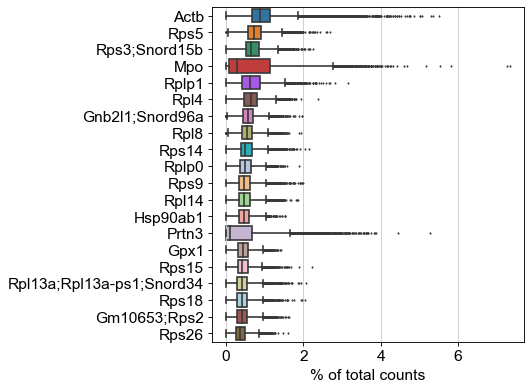

In [11]:
sc.pl.highest_expr_genes(adata_filtered, n_top=20, )

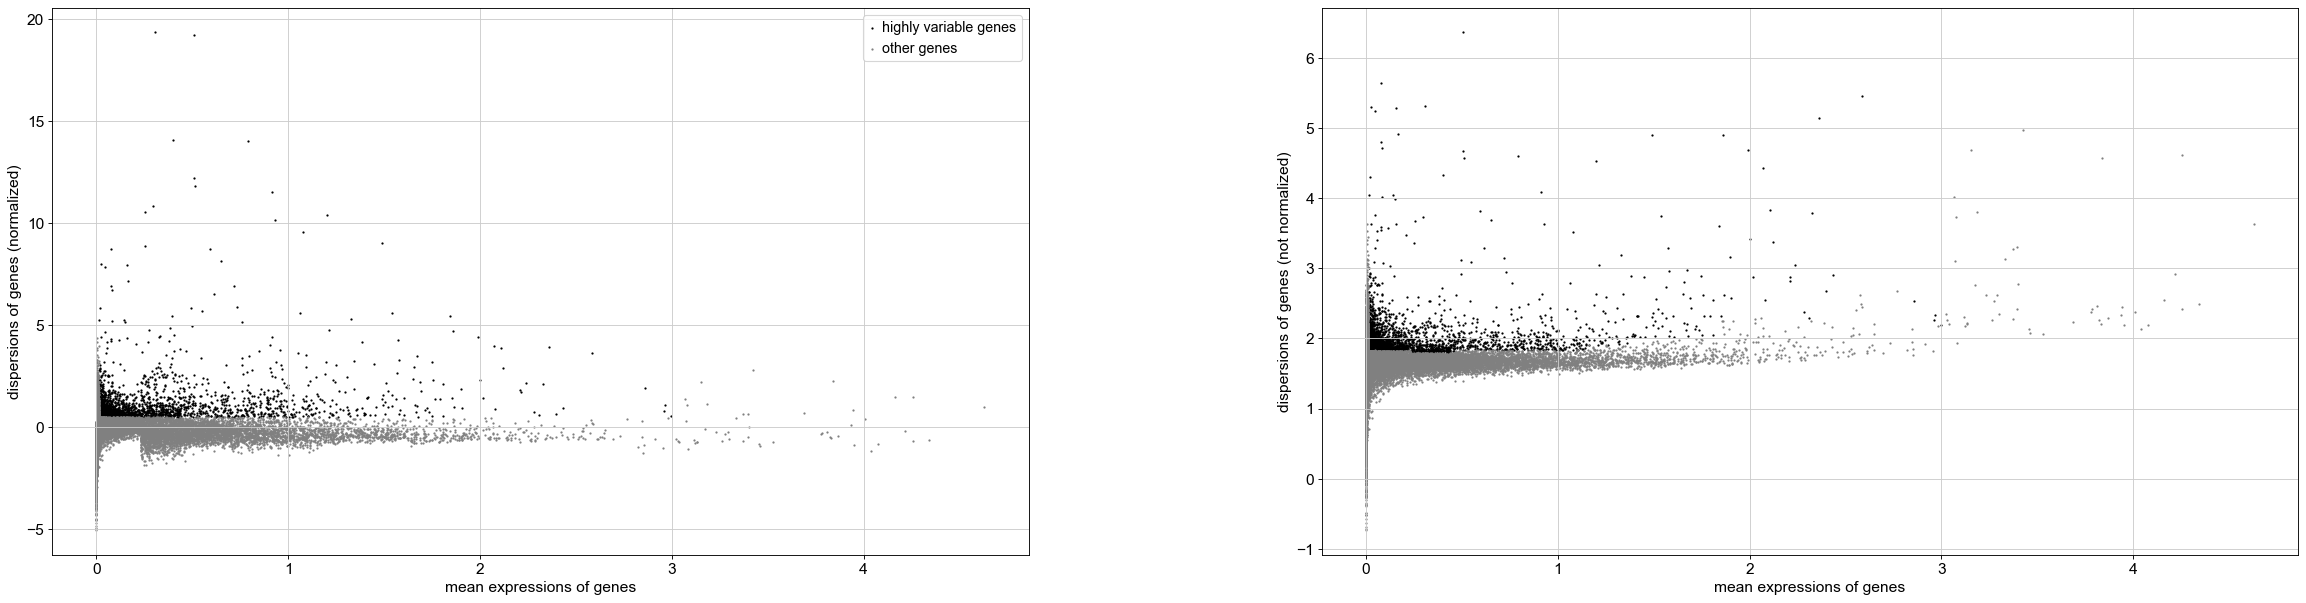

In [12]:
# within each cell, normalize count of genes to 10,000
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)
# filter out any genes with less than 0.0125/10,000 mean expression AND(?) dispersion (across all cells) less than 0.5
sc.pp.highly_variable_genes(adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_filtered)
adata_filtered.raw = adata_filtered

In [13]:
# TODO: look at what regress_out is doing for report
# may be able to implement cell cycle 
sc.pp.regress_out(adata_filtered, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_filtered, max_value=10)

# PCA

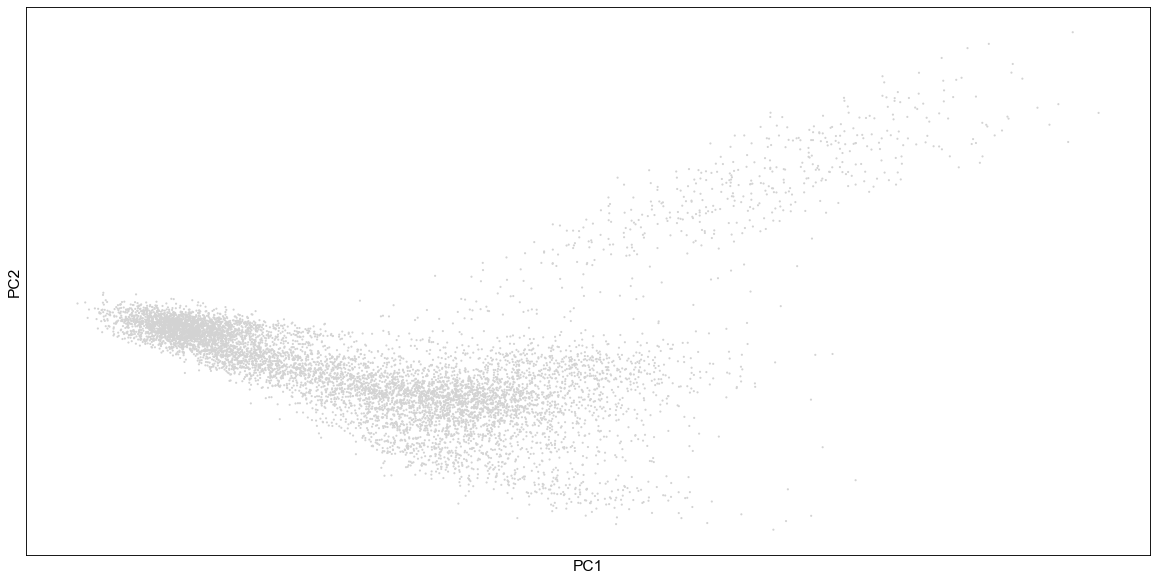

In [14]:
sc.tl.pca(adata_filtered, svd_solver='arpack') # TODO: look at 'arpack' svd solver
sc.pl.pca(adata_filtered) #, color='CST3')

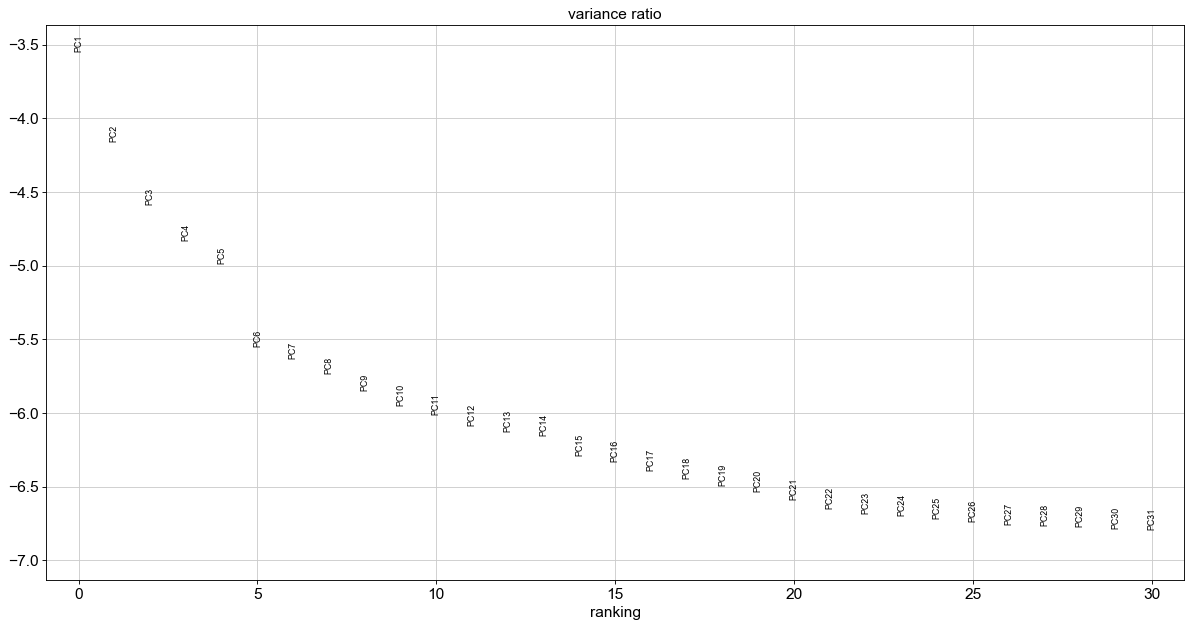

In [15]:
sc.pl.pca_variance_ratio(adata_filtered, log=True) # that's hot

In [16]:
adata_filtered.write(results_file)
adata_filtered

AnnData object with n_obs × n_vars = 8100 × 16162
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computing Neighborhood Graph

In [17]:
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=40)

# Embedding Neighborhood Graph

In [18]:
sc.tl.louvain(adata_filtered)

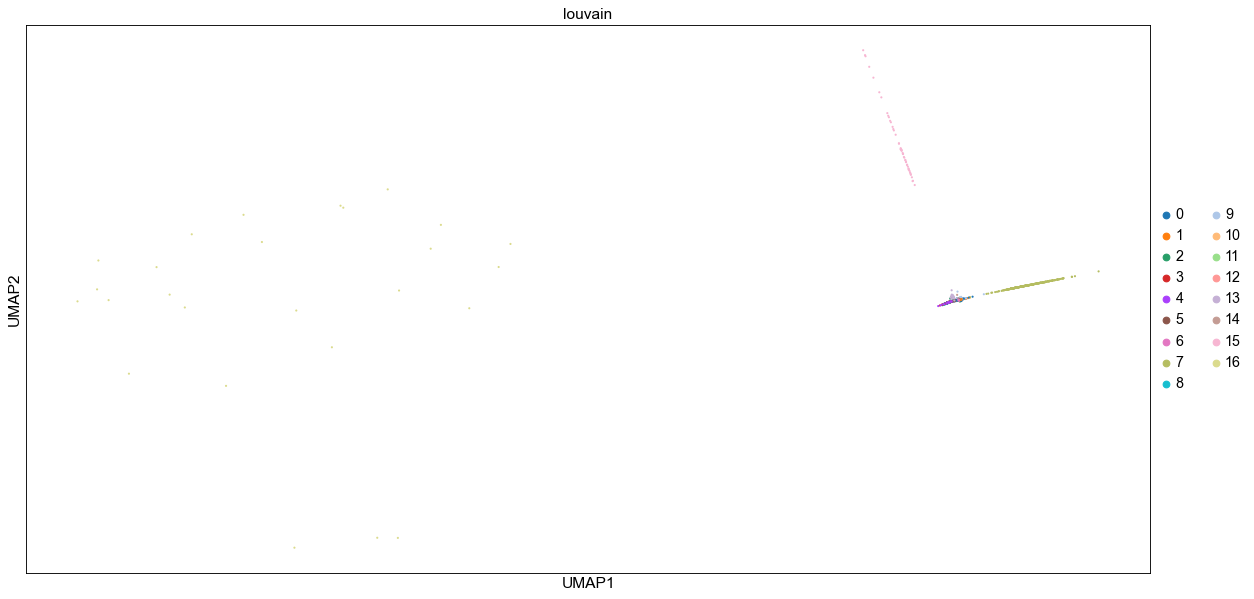

In [19]:
sc.tl.paga(adata_filtered)
sc.pl.paga(adata_filtered, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_filtered, init_pos='paga')
sc.tl.umap(adata_filtered)
sc.pl.umap(adata_filtered, color=['louvain']) #, color=['CST3', 'NKG7', 'PPBP'])

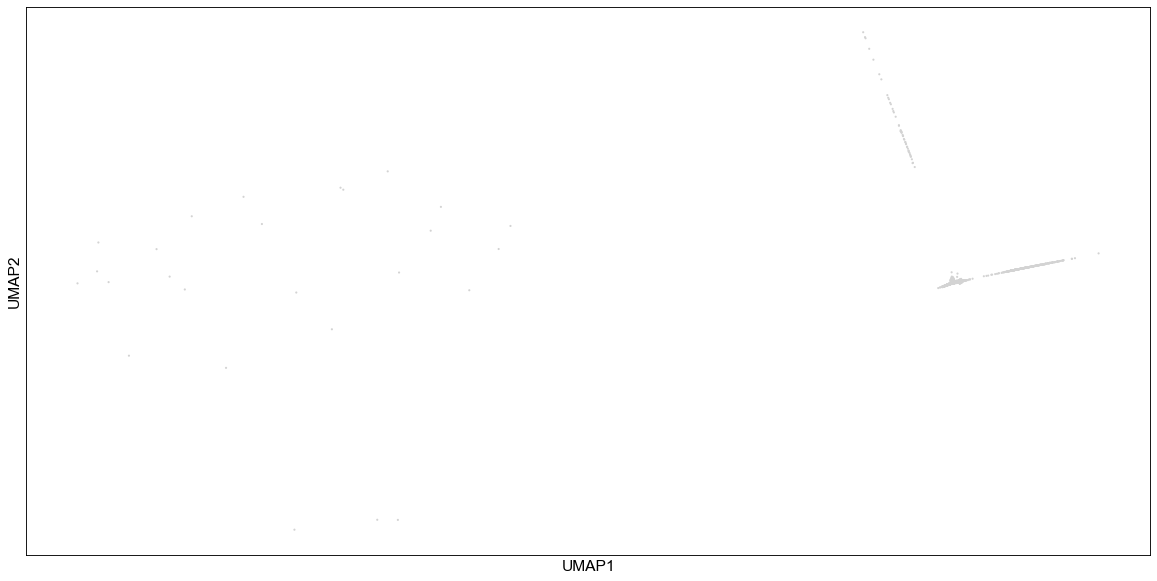

In [20]:
# see tutorial for what raw actually does, no significant difference vs above
sc.pl.umap(adata_filtered, use_raw=False) #, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

# Clustering Neighborhood Graph

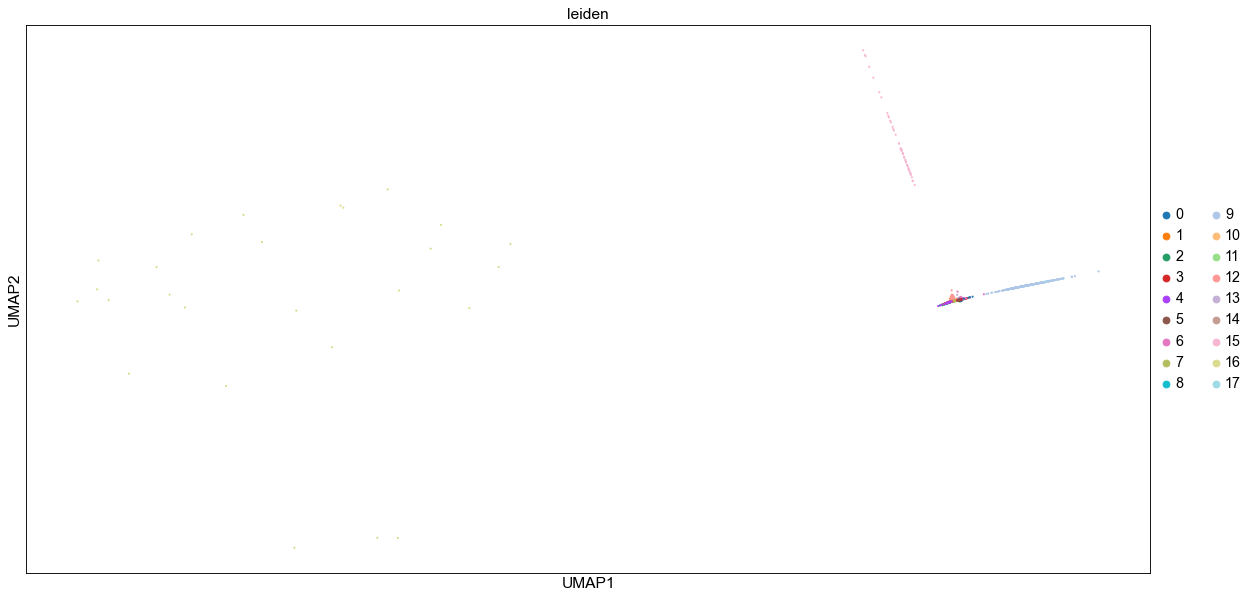

In [21]:
sc.tl.leiden(adata_filtered)
sc.pl.umap(adata_filtered, color=['leiden']) #, 'CST3', 'NKG7'])

In [22]:
adata_filtered.write(results_file)

# Finding Marker Genes

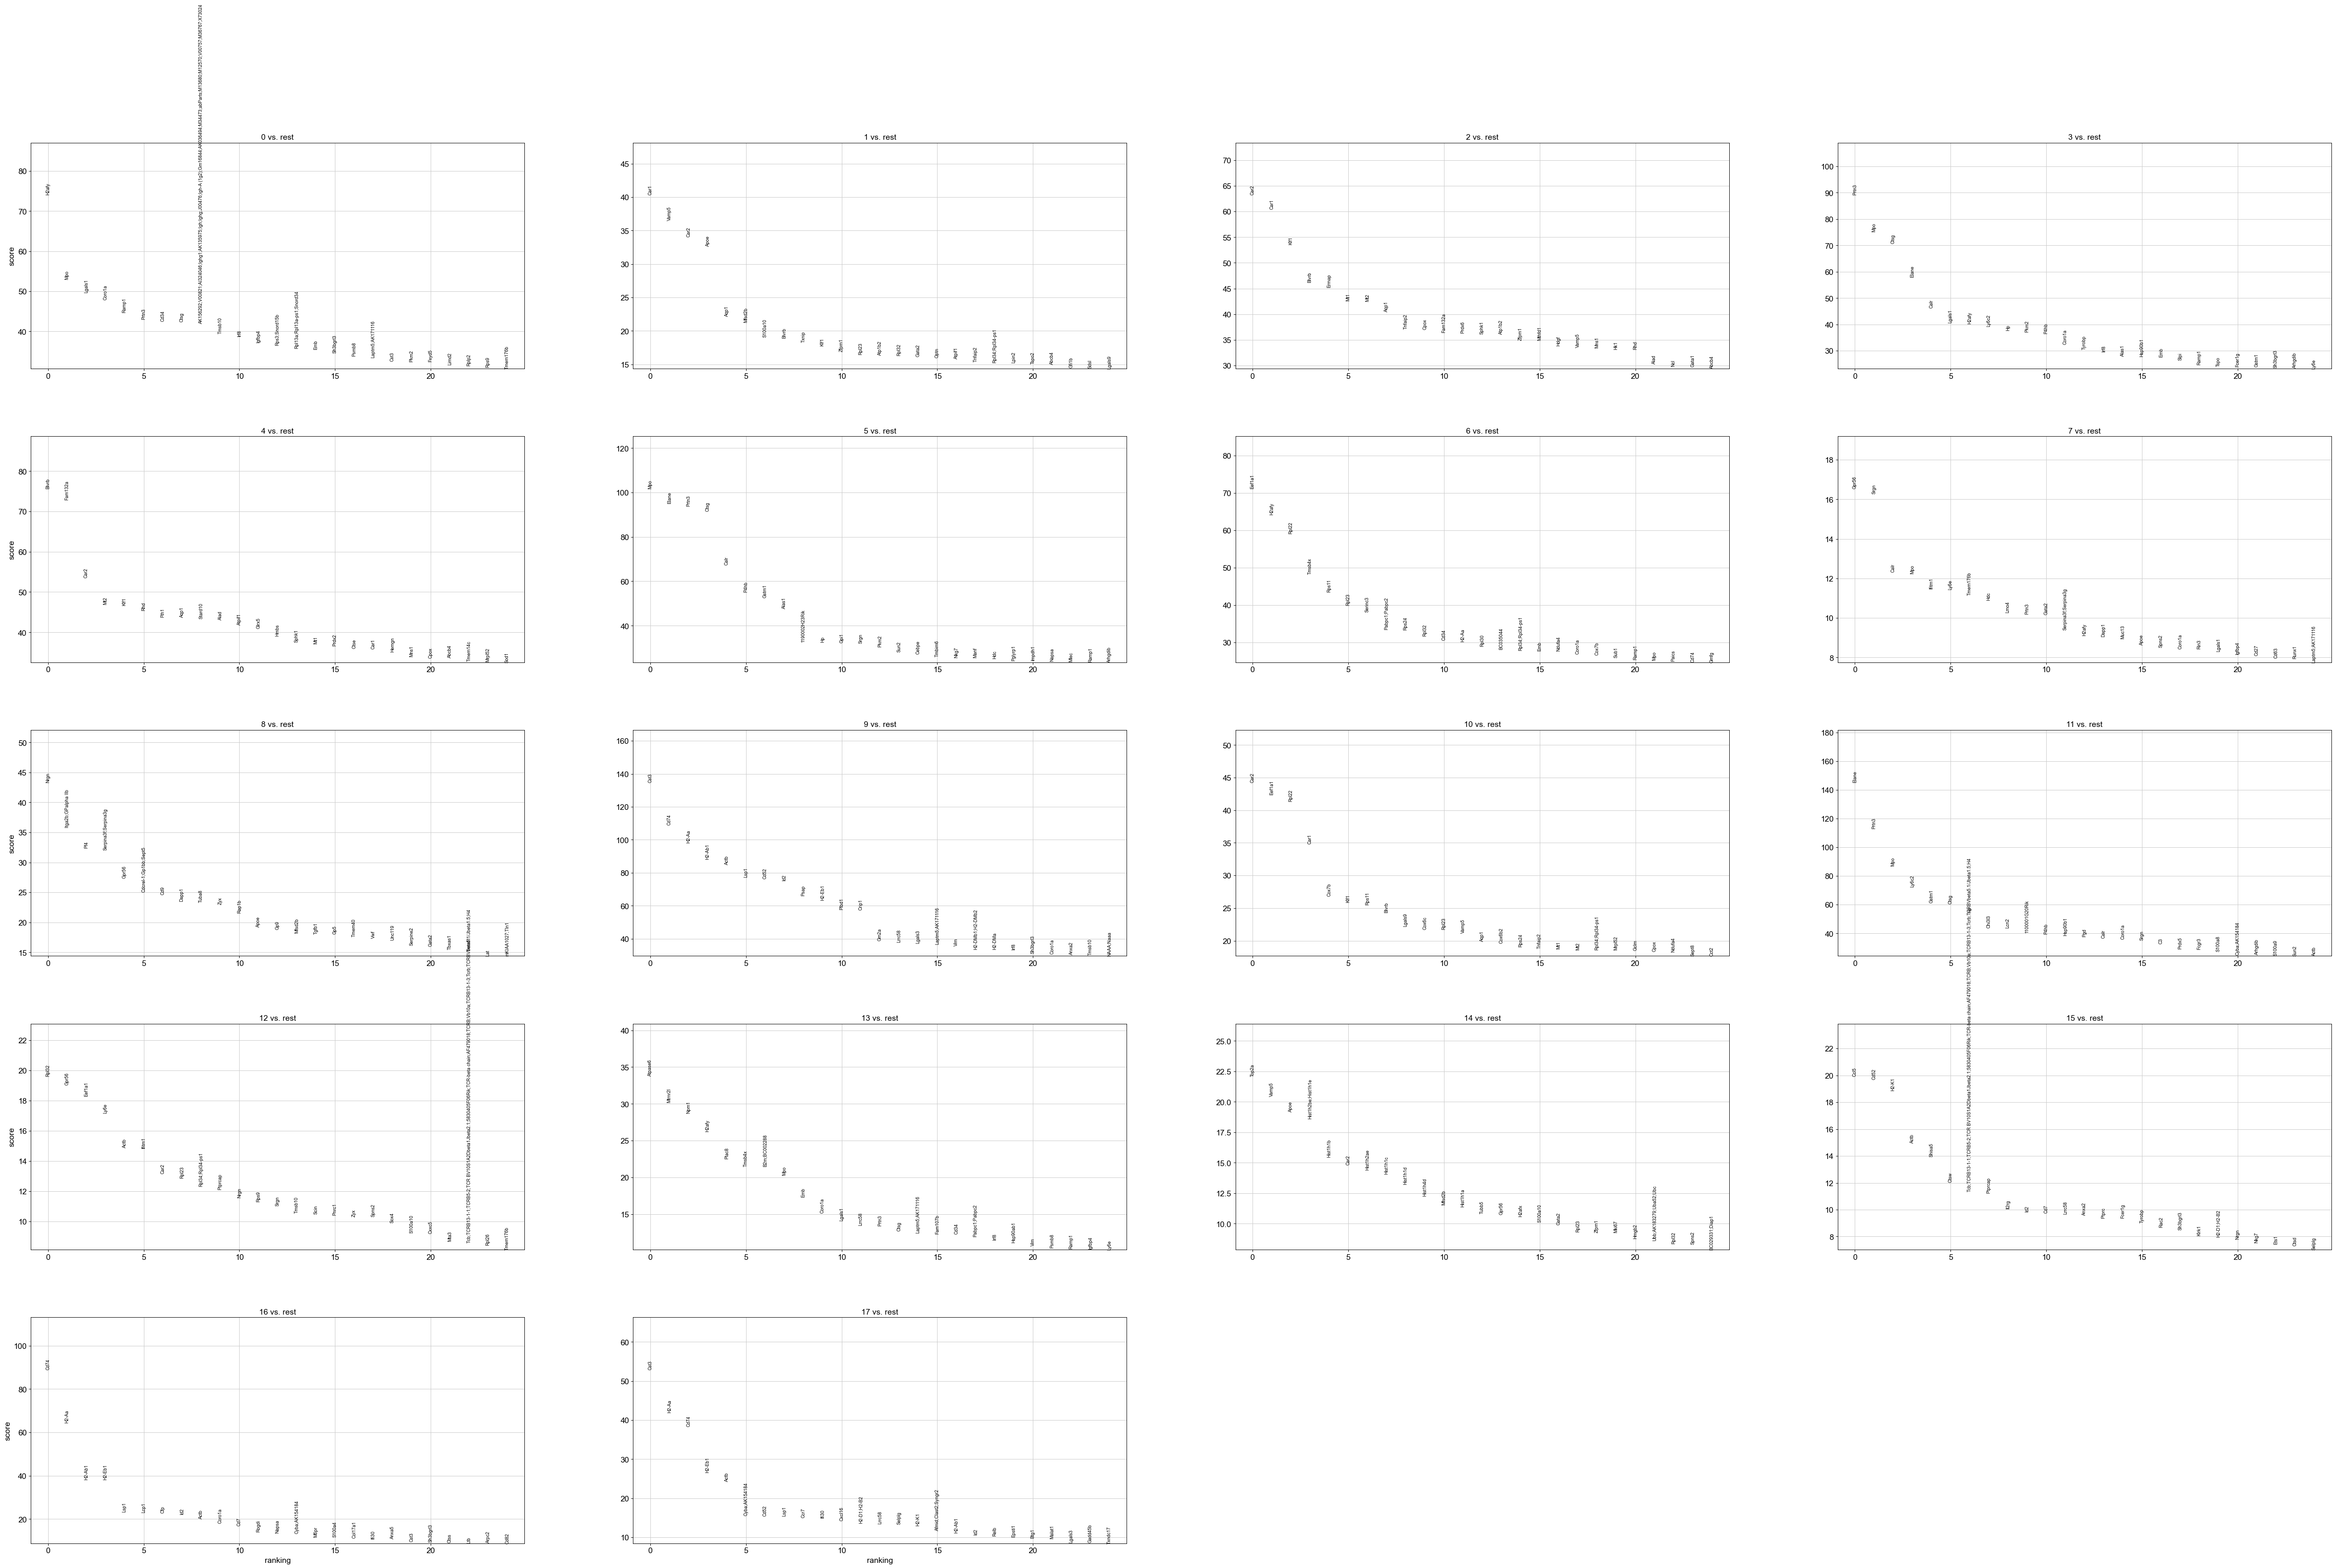

In [23]:
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

ranking genes
    finished (0:00:15)


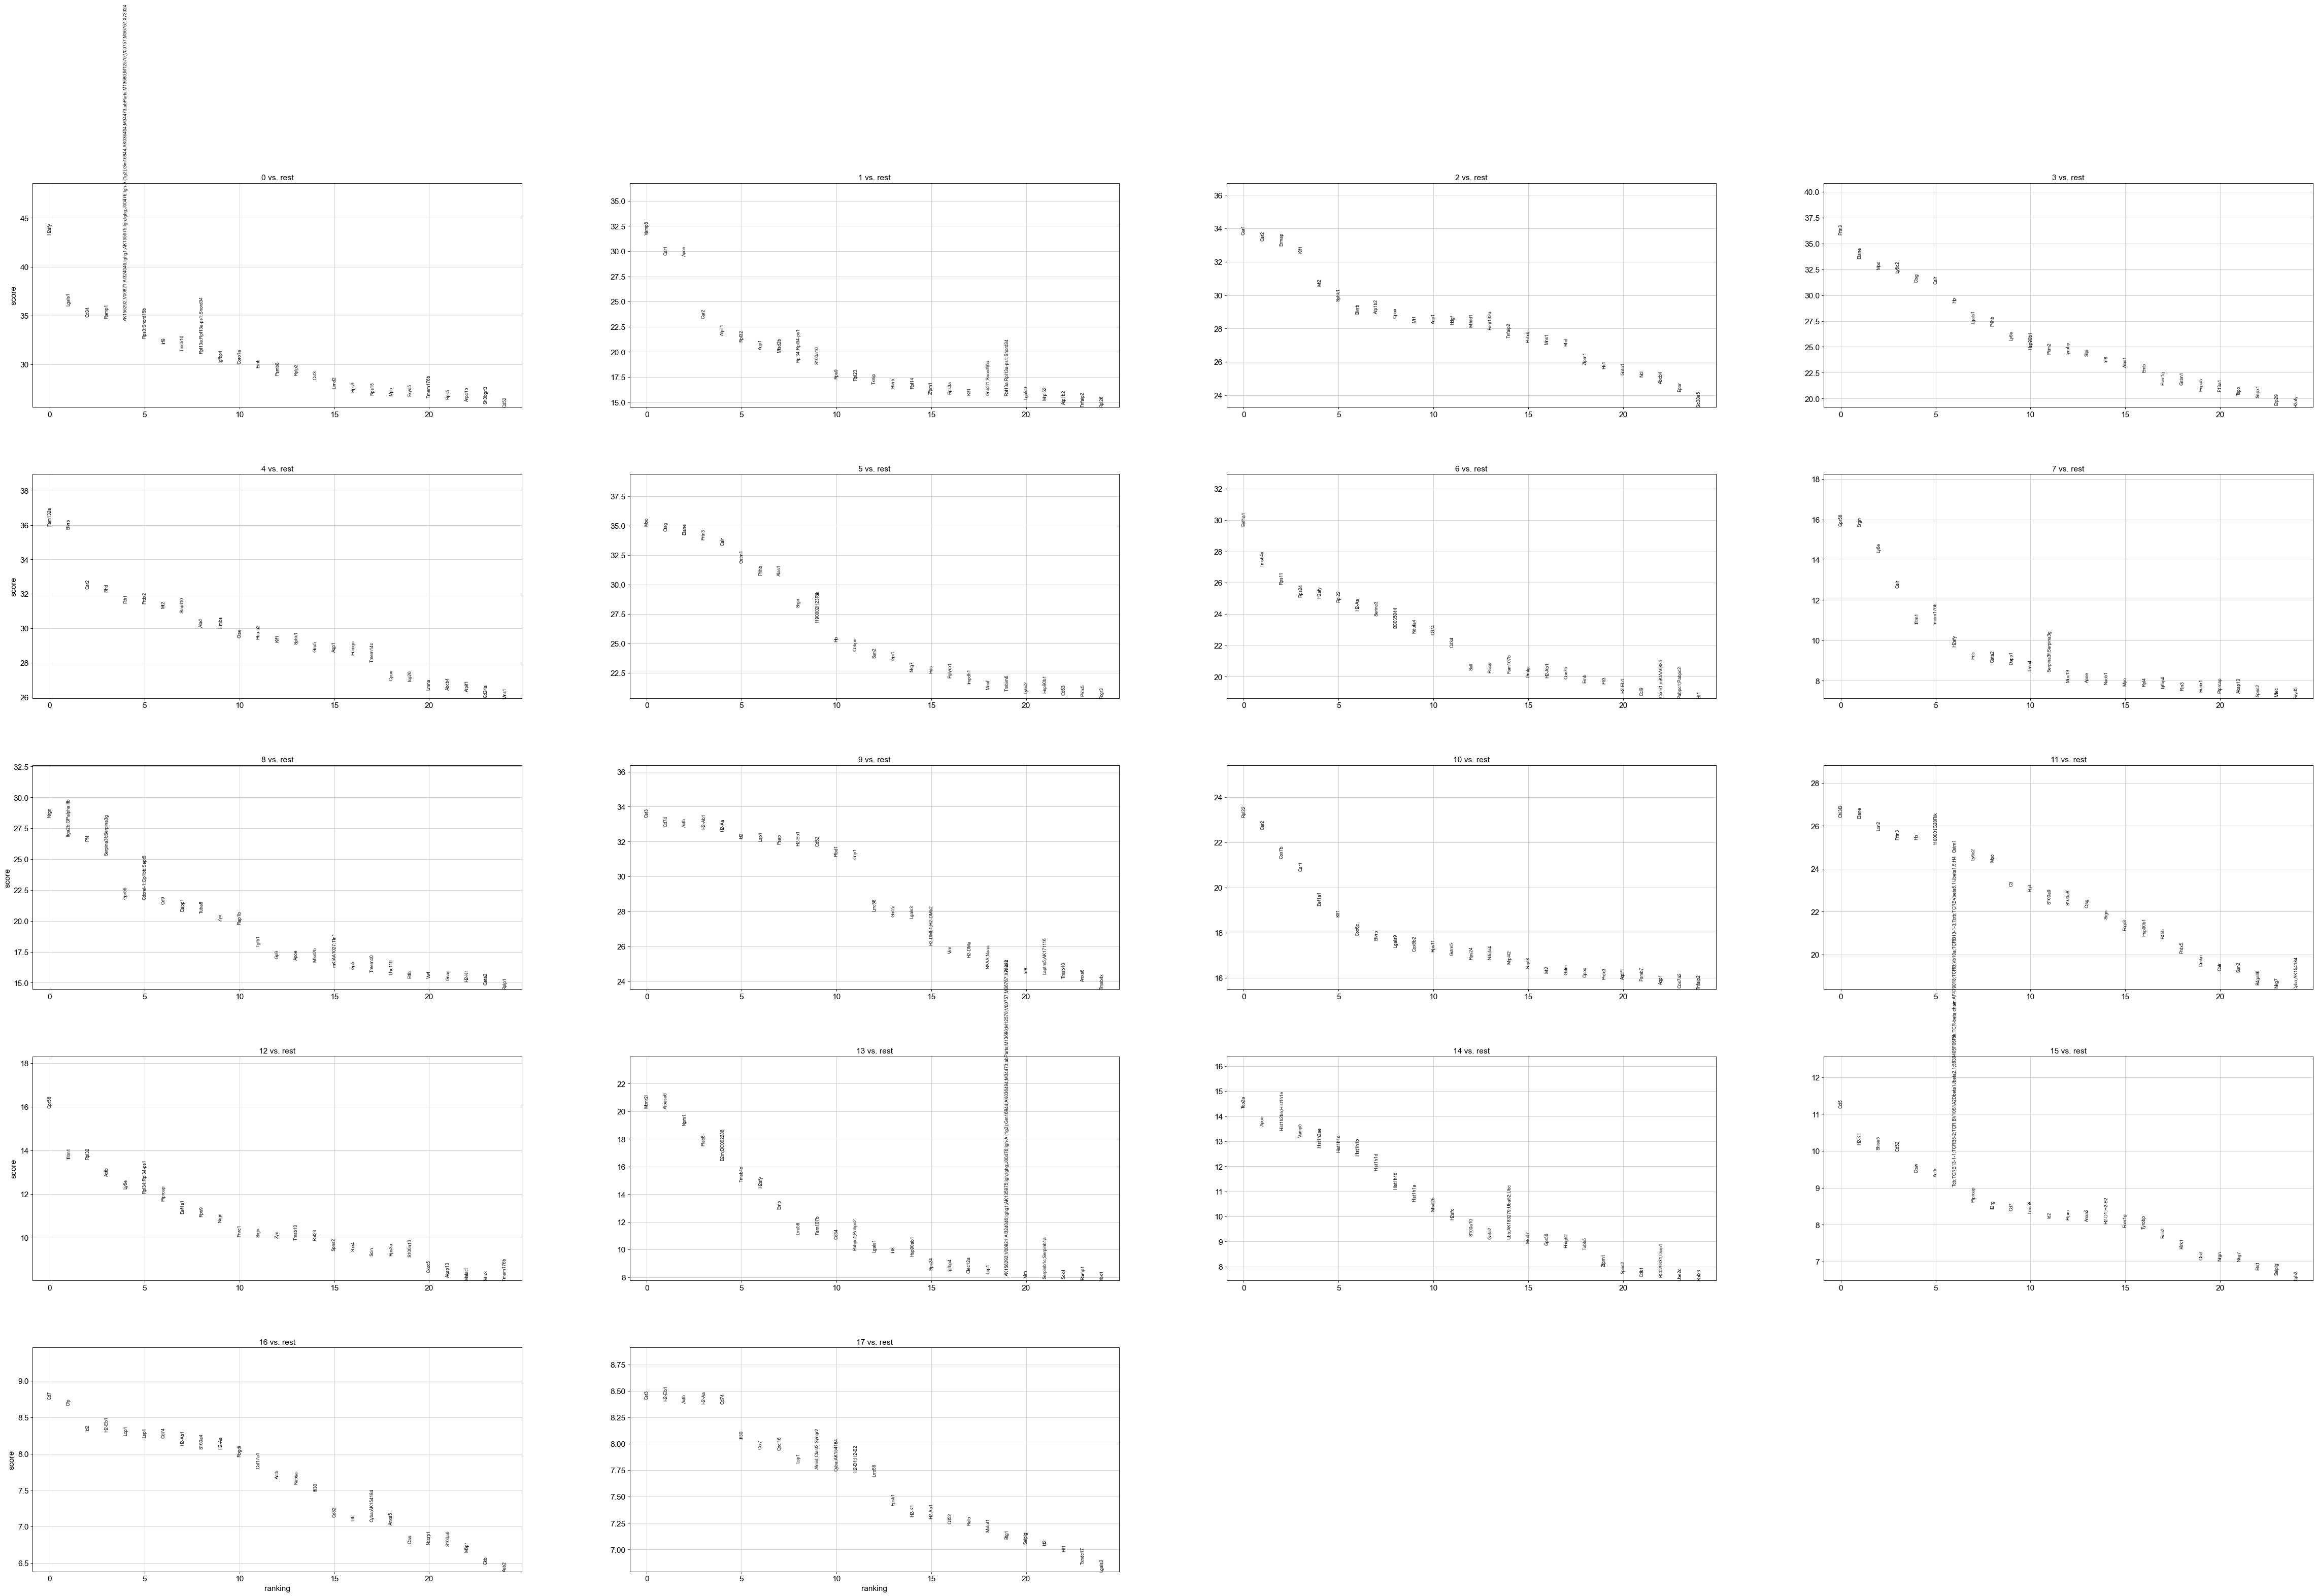

In [24]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [25]:
adata_filtered.write(results_file)

ranking genes
c:\Users\andissa\Anaconda3\envs\ml_project\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished (0:00:18)


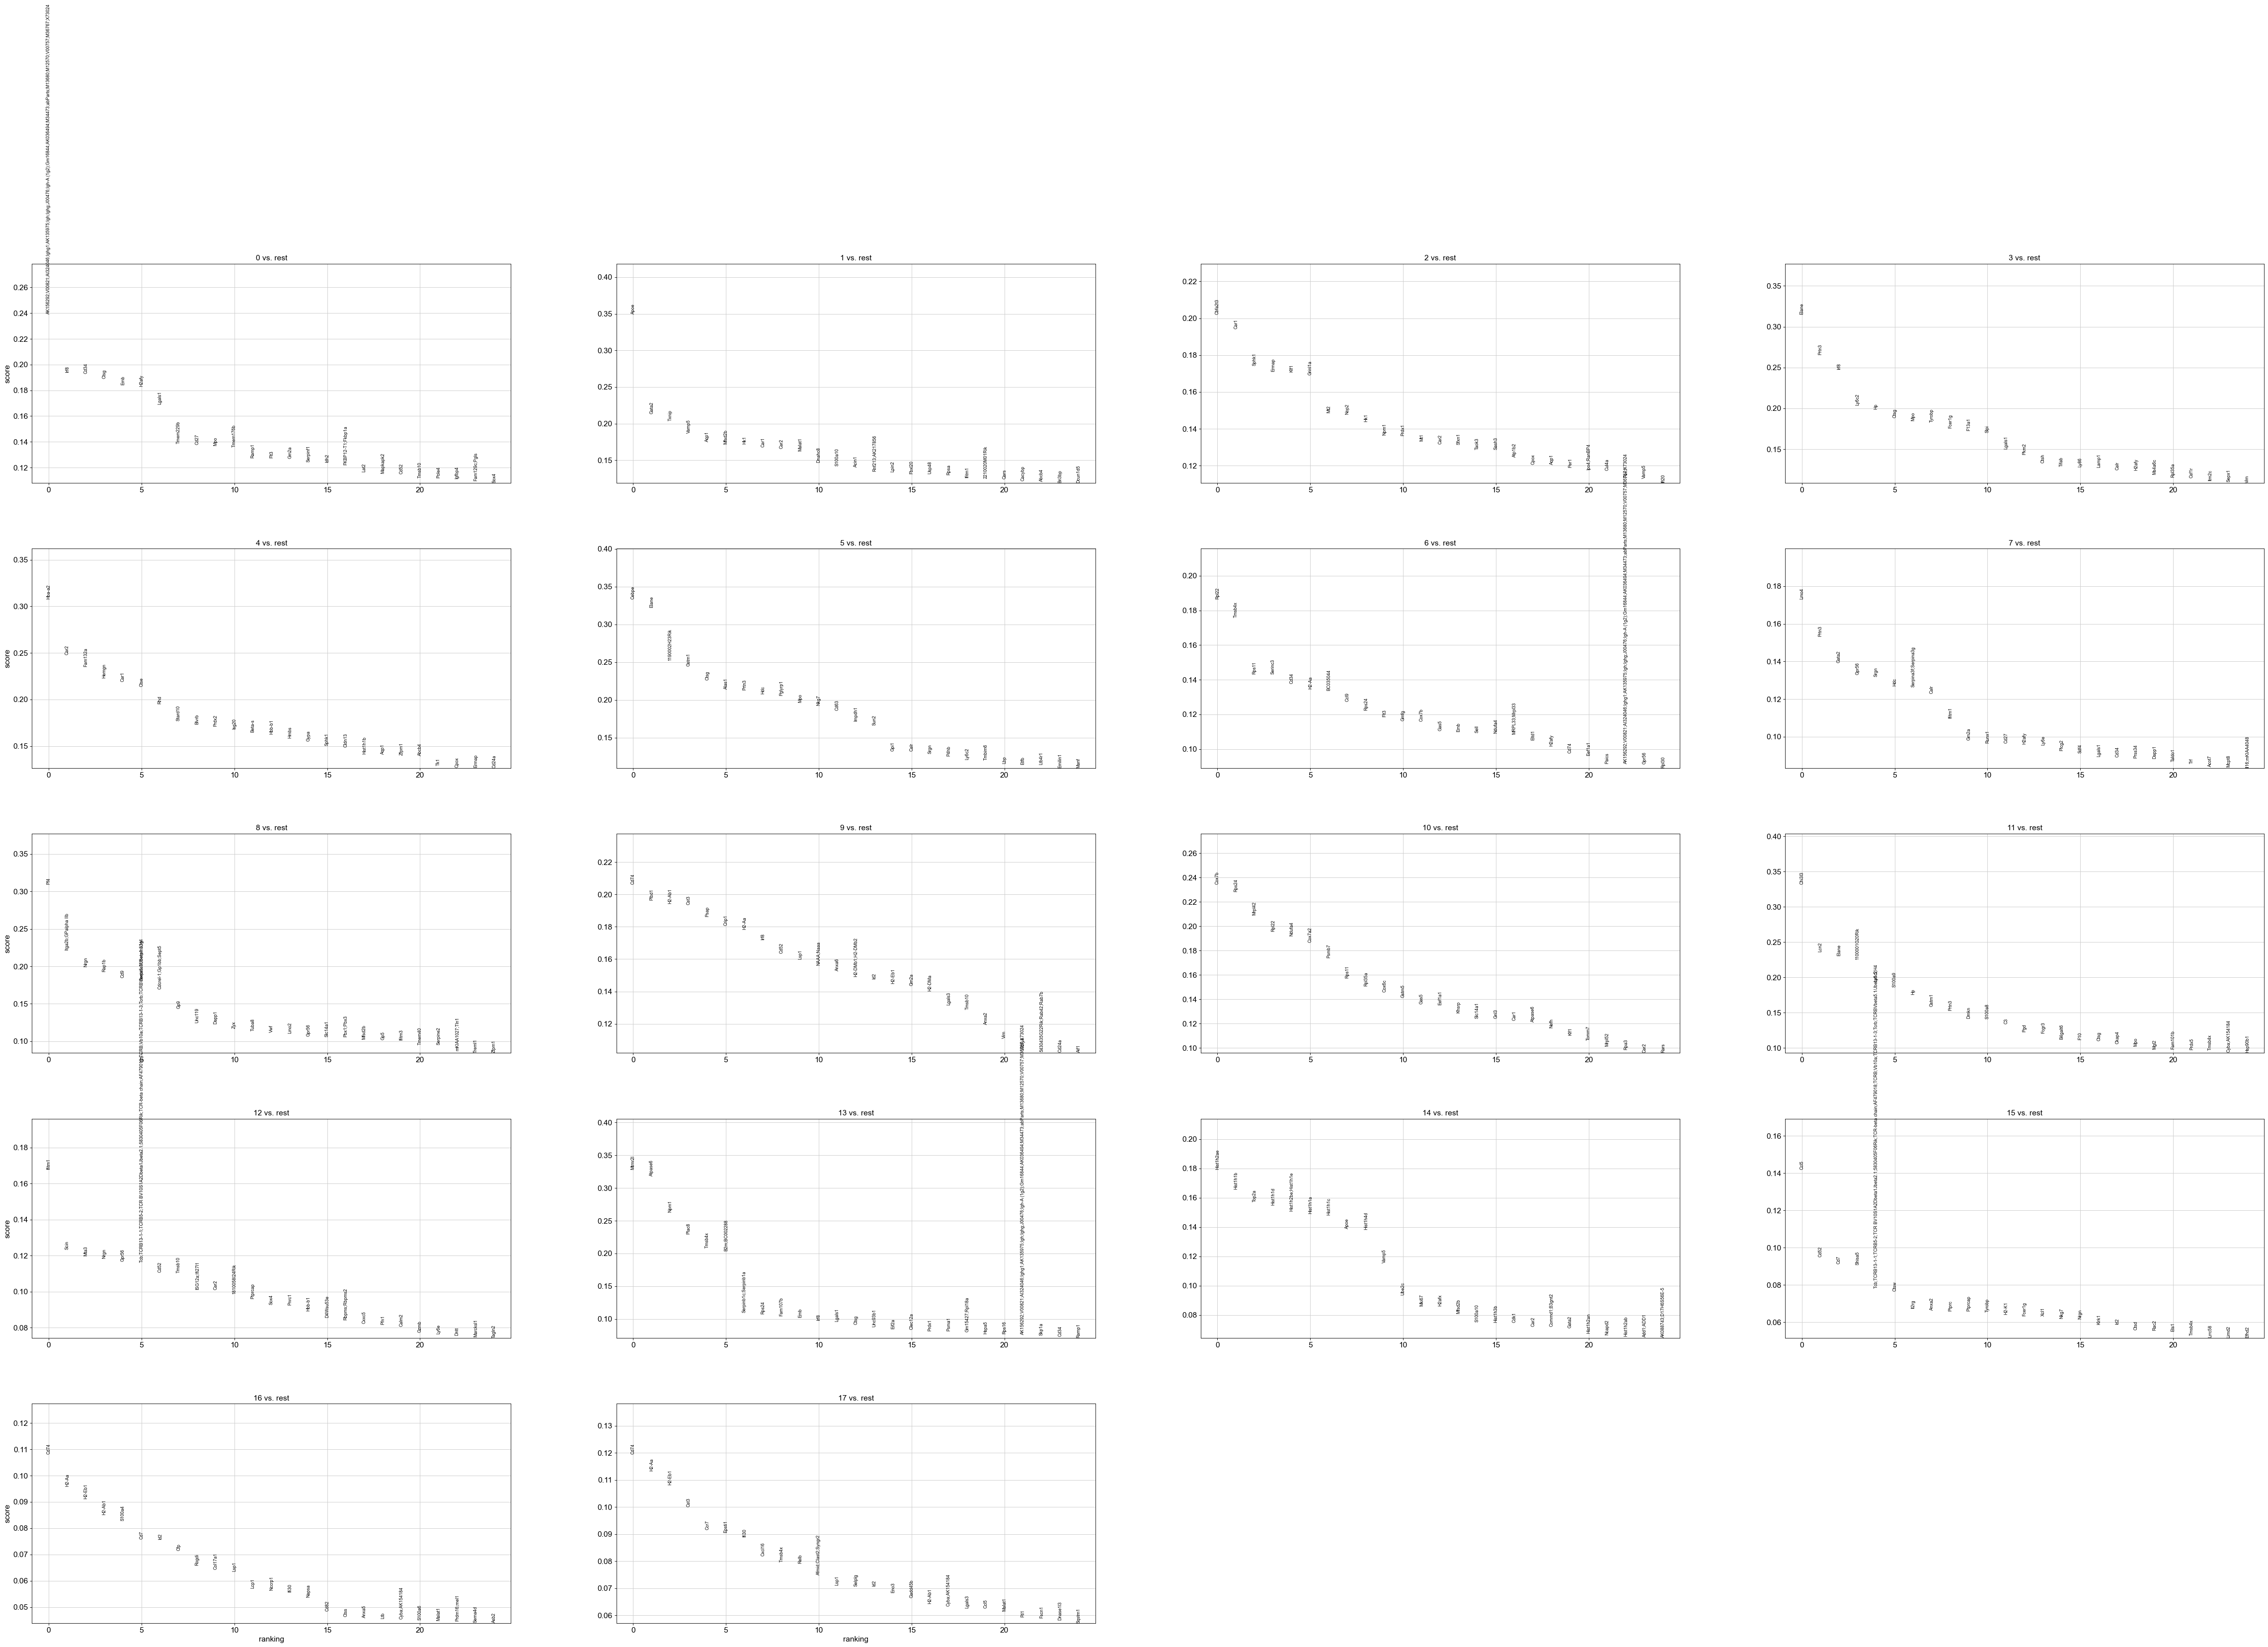

In [26]:
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [27]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [28]:
adata = sc.read(results_file)

In [29]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,H2afy,Vamp5,Car1,Prtn3,Fam132a,Mpo,Eef1a1,Gpr56,Nrgn,Cst3,Rpl22,Chi3l3,Gpr56,Mtrnr2l,Top2a,Ccl5,Cd7,Cst3
1,Lgals1,Car1,Car2,Elane,Blvrb,Ctsg,Tmsb4x,Srgn,Itga2b;GPalpha IIb,Cd74,Car2,Elane,Ifitm1,Atpase6,Apoe,H2-K1,Cfp,H2-Eb1
2,Cd34,Apoe,Ermap,Mpo,Car2,Elane,Rps11,Ly6e,Pf4,Actb,Cox7b,Lcn2,Rpl32,Npm1,Hist1h2be;Hist1h1e,Shisa5,Id2,Actb
3,Ramp1,Car2,Klf1,Ly6c2,Rhd,Prtn3,Rps24,Calr,Serpina3f;Serpina3g,H2-Ab1,Car1,Prtn3,Actb,Plac8,Vamp5,Cd52,H2-Eb1,H2-Aa
4,AK156292;V00821;AI324046;Ighg1;AK135975;Igh;Ig...,Atpif1,Mt2,Ctsg,Fth1,Calr,H2afy,Ifitm1,Gpr56,H2-Aa,Eef1a1,Hp,Ly6e,B2m;BC002288,Hist1h2ae,Ctsw,Lcp1,Cd74


In [30]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p,17_n,17_p
0,H2afy,0.000000e+00,Vamp5,1.324893e-219,Car1,9.335582e-248,Prtn3,2.636372e-281,Fam132a,5.107859e-283,...,Mtrnr2l,5.464456e-91,Top2a,1.574132e-46,Ccl5,6.346571e-29,Cd7,2.178513e-18,Cst3,3.752866e-17
1,Lgals1,1.035157e-283,Car1,1.105775e-192,Car2,1.871445e-242,Elane,7.494749e-247,Blvrb,1.735692e-280,...,Atpase6,1.508835e-90,Apoe,3.716878e-42,H2-K1,2.656120e-24,Cfp,4.649072e-18,H2-Eb1,4.172299e-17
2,Cd34,3.732710e-266,Apoe,5.944031e-191,Ermap,4.506305e-238,Mpo,8.593012e-232,Car2,1.555477e-228,...,Npm1,2.281700e-80,Hist1h2be;Hist1h1e,3.702003e-41,Shisa5,1.016980e-23,Id2,9.185591e-17,Actb,5.260824e-17
3,Ramp1,2.312405e-264,Car2,2.378065e-120,Klf1,2.383586e-232,Ly6c2,3.924596e-227,Rhd,3.287299e-226,...,Plac8,6.562329e-69,Vamp5,1.323325e-39,Cd52,1.659934e-23,H2-Eb1,1.015681e-16,H2-Aa,5.384772e-17
4,AK156292;V00821;AI324046;Ighg1;AK135975;Igh;Ig...,2.261935e-260,Atpif1,1.266738e-103,Mt2,3.944493e-205,Ctsg,2.244974e-214,Fth1,3.582378e-217,...,B2m;BC002288,9.241473e-61,Hist1h2ae,3.081407e-37,Ctsw,4.782102e-21,Lcp1,1.539268e-16,Cd74,5.451786e-17


ranking genes
    finished (0:00:01)


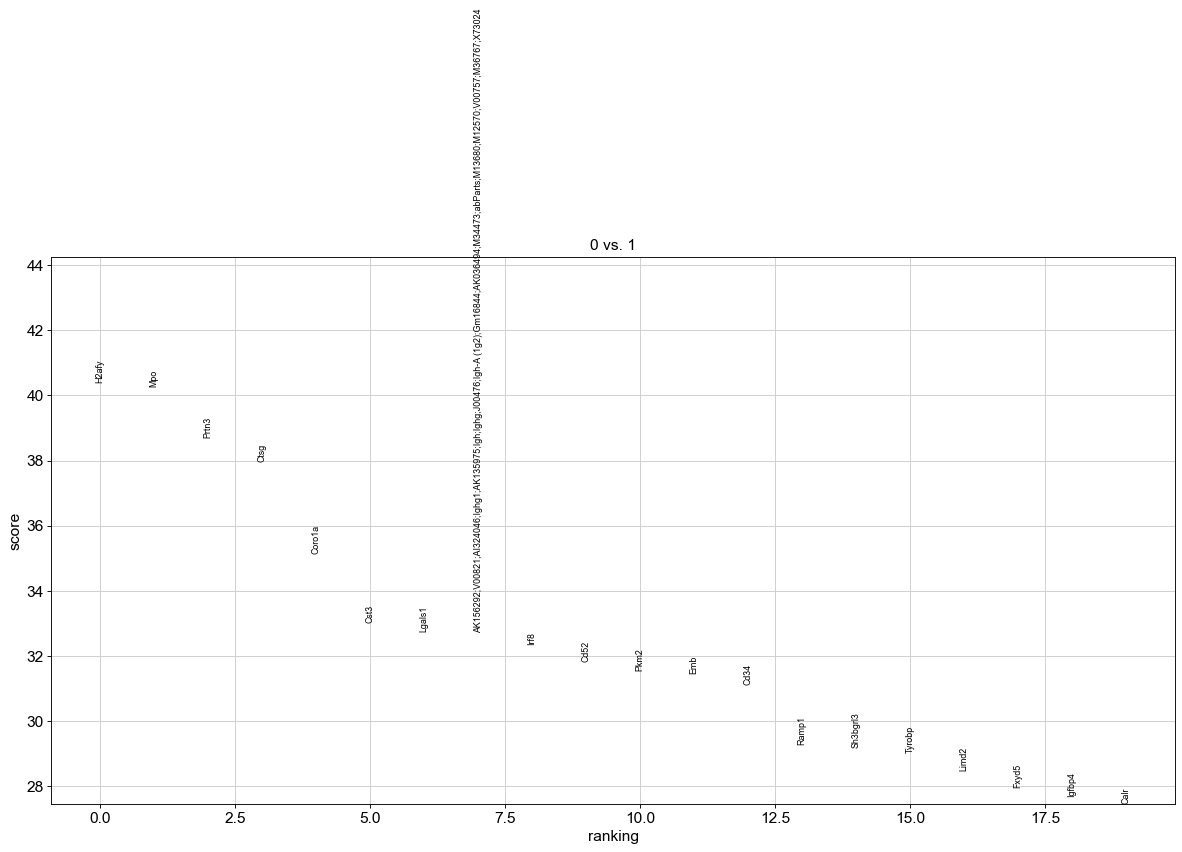

In [31]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [32]:
#sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [33]:
# adata = sc.read(results_file)
# sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [34]:
#sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [35]:
# new_cluster_names = [
#     'CD4 T', 'CD14 Monocytes',
#     'B', 'CD8 T',
#     'NK', 'FCGR3A Monocytes',
#     'Dendritic', 'Megakaryocytes']
# adata.rename_categories('leiden', new_cluster_names)

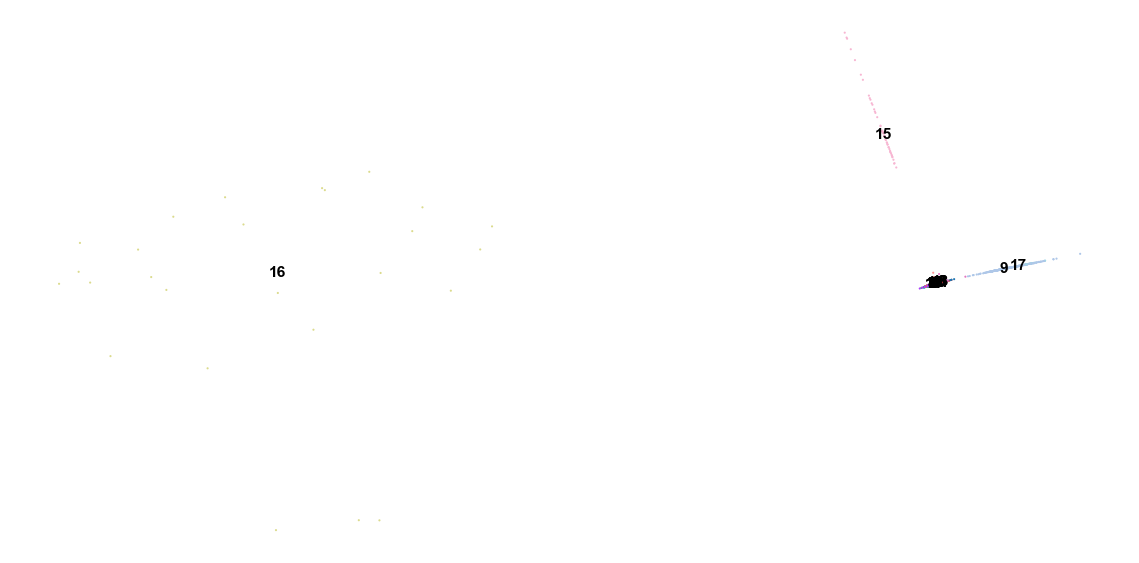

In [36]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [37]:
#sc.pl.dotplot(adata, marker_genes, groupby='leiden');

# Trajectory Analysis

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:01)
drawing single-cell graph using layout 'fa'
    finished (0:01:12)


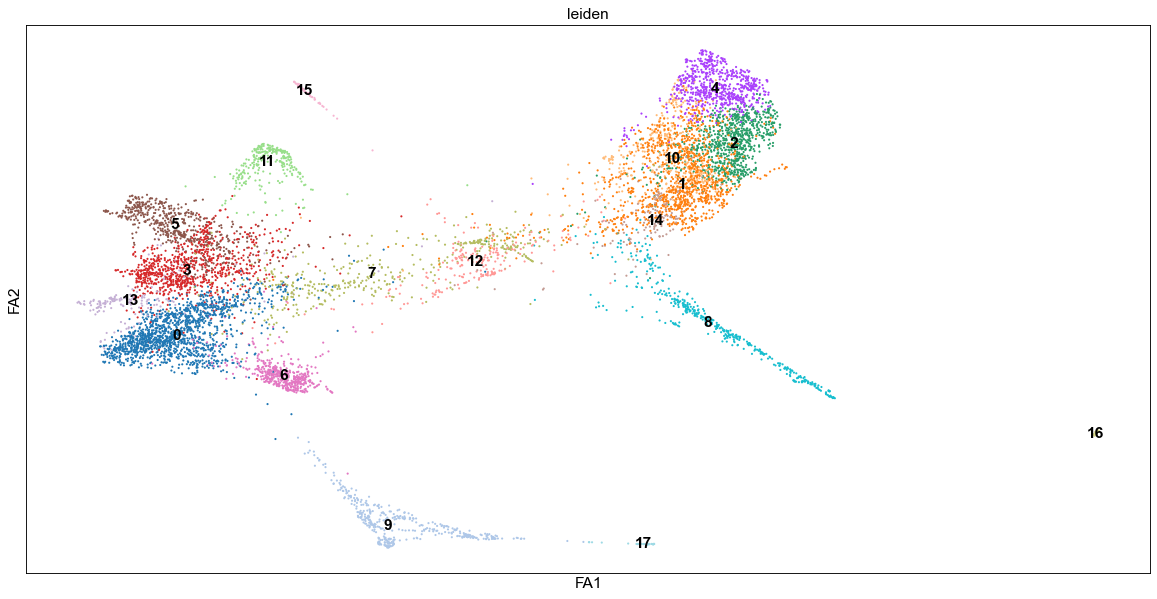

In [38]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

## Graph Denoising

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99915016 0.9981264  0.9976041  0.9974042
     0.99664325 0.99553597 0.99059707 0.99021244 0.9892284  0.9882512
     0.9859211  0.9852927  0.9811345 ]
    finished (0:00:00)
computing neighbors
    finished (0:00:01)
drawing single-cell graph using layout 'fa'
    finished (0:01:07)


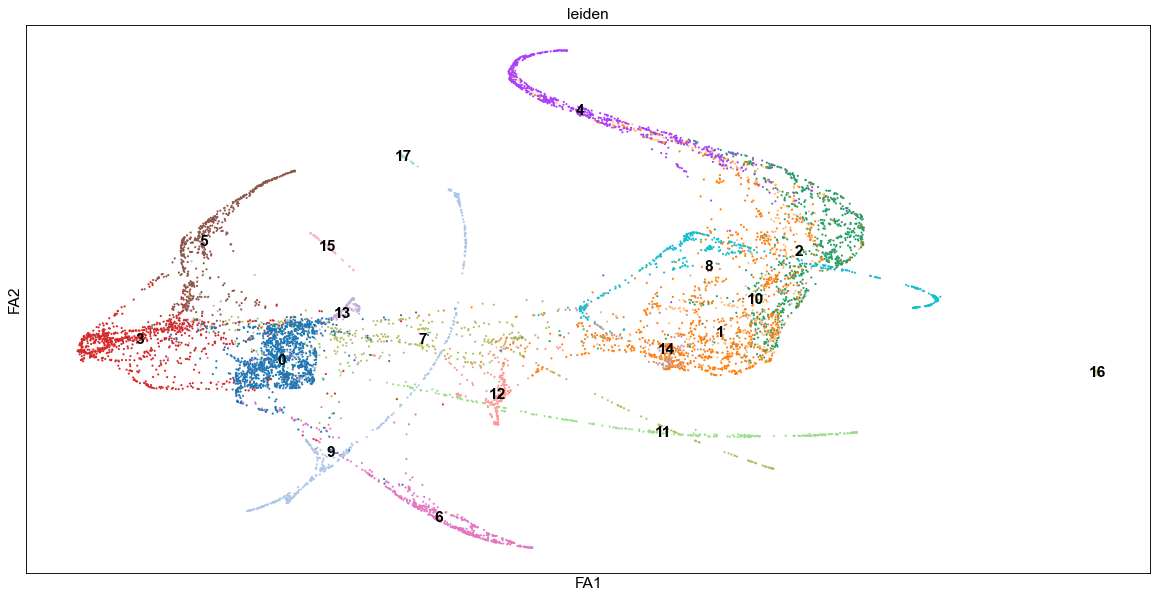

In [39]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

## Clustering and PAGA

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running PAGA
    finished (0:00:00)


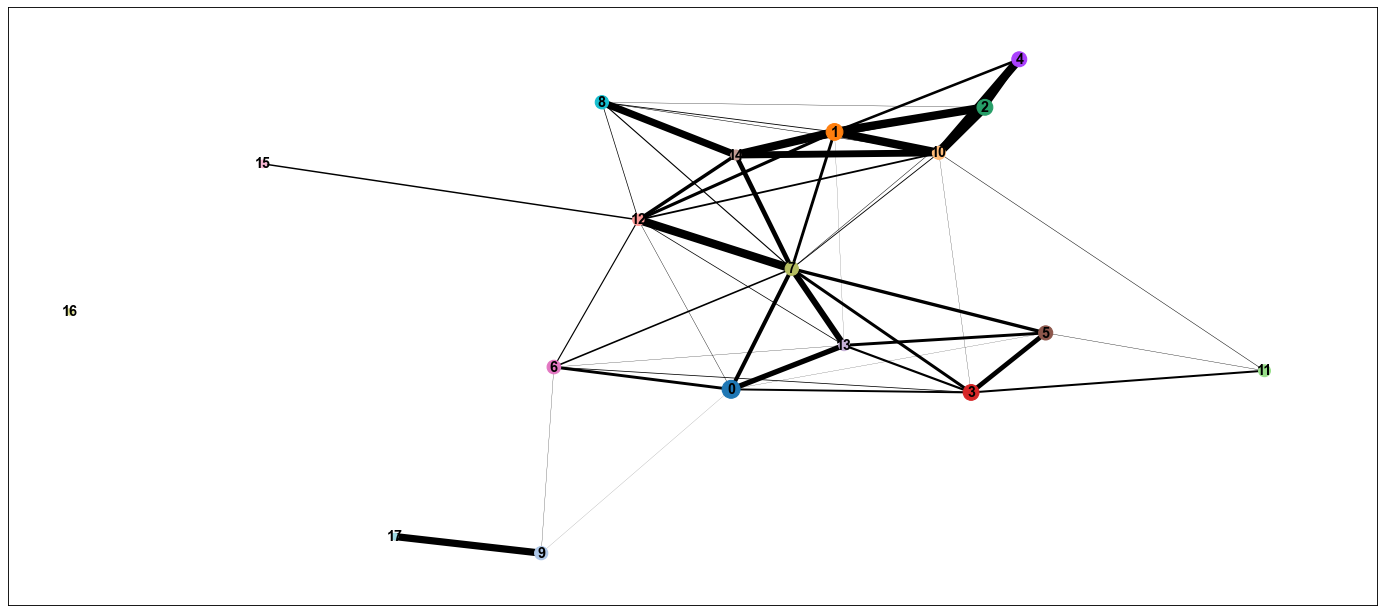

In [40]:
sc.tl.louvain(adata,resolution=1.0)
sc.tl.paga(adata)
sc.pl.paga(adata) #, 'Hba-a2', 'Elane', 'Irf8'

In [41]:
# Annotations?
# FIGURE OUT IF ANNOTATIONS ARE NECESSARY

## DPT

In [42]:
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

ValueError: new categories need to have the same number of items as the old categories!

# Cell Cycle Regression

In [ ]:
cell_cycle_file = 'cell_cycle_genes.txt'

cell_cycle_genes = [x.strip() for x in open(cell_cycle_file)]

s_genes = cell_cycle_genes[:91]
g2m_genes = cell_cycle_genes[91:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_filtered.var_names]

sc.tl.score_genes_cell_cycle(adata_filtered, s_genes, g2m_genes)

... storing 'phase' as categorical


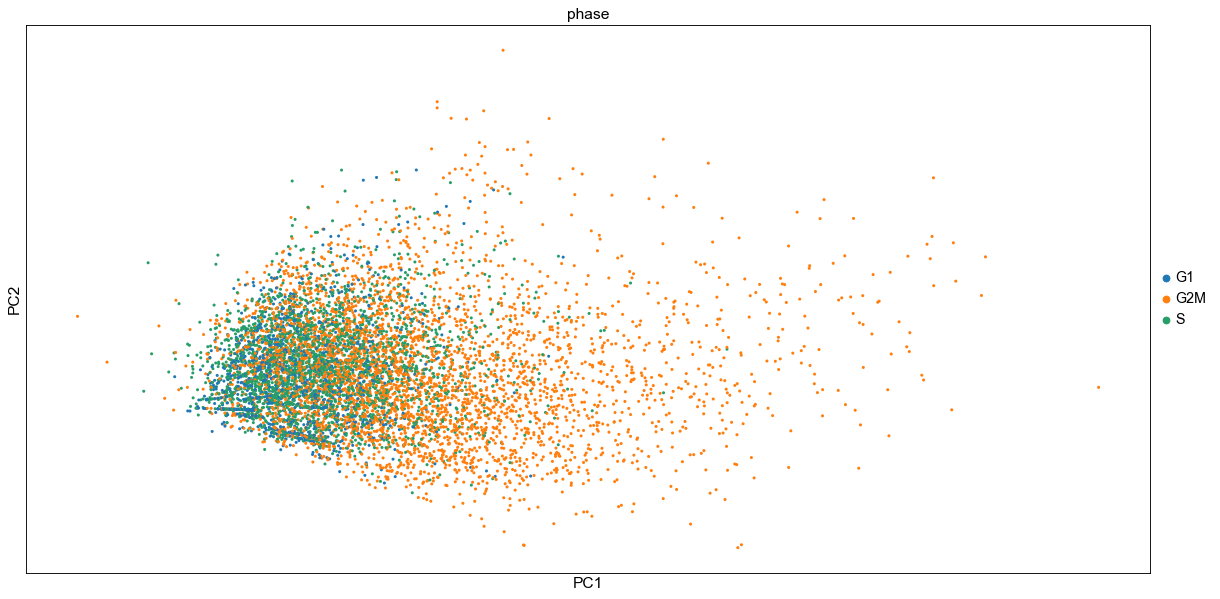

In [ ]:
#sc.settings.set_figure_params(dpi=80)
adata_cc_genes = adata_filtered[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca(adata_cc_genes, color='phase', size = 30)
#Plot: PCA before regressing out cell-cycle genes

... storing 'phase' as categorical


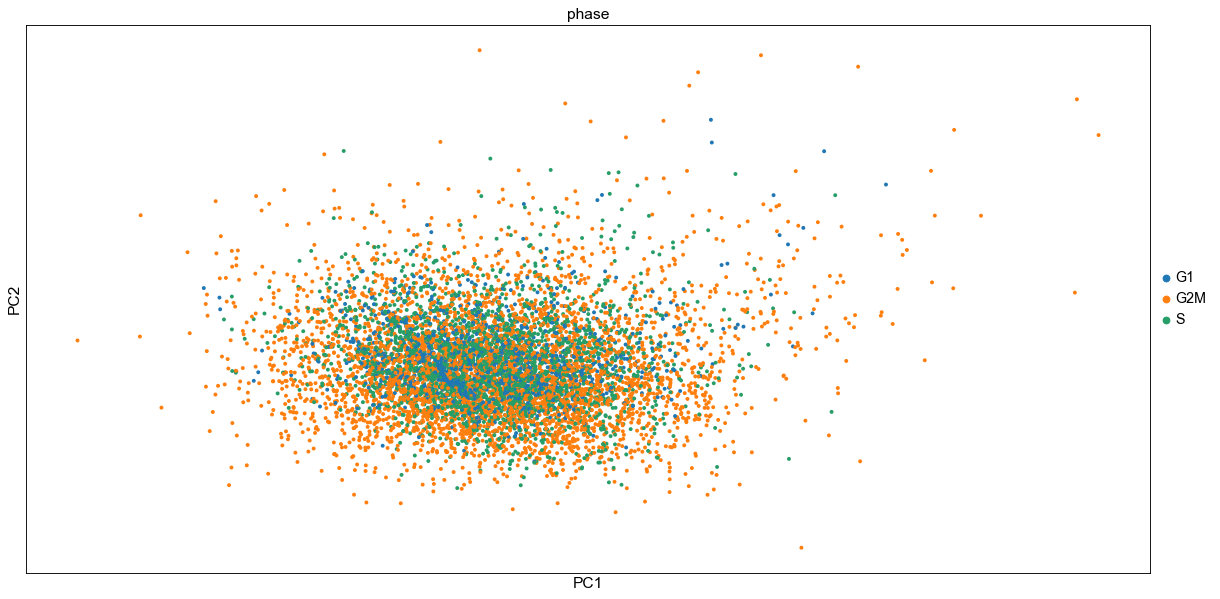

In [ ]:
sc.pp.regress_out(adata_filtered, ['S_score', 'G2M_score'])
sc.pp.scale(adata_filtered)

#adata_cc_genes constains the data with regressed out cell-cycle effects
adata_cc_genes = adata_filtered[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca(adata_cc_genes, color='phase', size = 50)
#Plot: PCA after regressing out cell-cycle genes